# Esimerkki VQE algoritmista

https://qiskit.org/textbook/ch-applications/vqe-molecules.html#VQE-Implementation-in-Qiskit

## Huomioita (Laurilta)

- Käyttää suoraan qiskit kirjastoa, ei hyödynnä tequilaa
- laskee molekyylin perustason energian LiH molekyylin kahden atomin eri etäisyyksillä
- backend: lokaalisti ajettava qiskitin oma kvanttikonesimulaattori "statevector_simulator"

### Miten about toimii??

Tämä määrittelee kvanttikoneessa pyöräytettävän algoritmin

```vqe = VQE(qubitOp, var_form, optimizer)```

- qubitOp = Qubit operator of the Observable (tämä on molekyylin perusteella rakennettu Hamiltonian?)
- optimizer = klassisella koneella ajettava optimointialgoritmi, jota ajetaan jokaisen iteraation lopuksi jotta saadaan seuraavan iteraation konfiguraatio?
- var_form = A parameterized circuit used as Ansatz for the wave function (Ikäänkuin aloituskonfiguraatio?)

### Algoritmin tiedot

- Nimi: Ciskit VQE example
- Algoritmin tyyppi: VQE(UCCSD)?
- Molekyyli: LiH (Lithium hydride)

### Metriikat

- iterations: max 5?, koska ```optimizer = SLSQP(maxiter=5)```. Mutta todellisen määrän saa tietää vain simuloimalla? ```vqe.run(backend)``` palauttaa dictin jossa dataa, voiko siitä päätellä?
- measurements: ?
- circuit_depth: 100? Tuon mukaan Hamiltonianissa on 100 pauli-porttia?
- accuracy: algoritmin tulos on -7.881014174031252, mikä on oikea arvo?

Riippuvuudet (ainakin): qiskit, PySCF

In [2]:
from qiskit.aqua.algorithms import VQE, NumPyEigensolver
import matplotlib.pyplot as plt
import numpy as np
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
from qiskit.aqua.operators import Z2Symmetries
from qiskit.aqua import QuantumInstance
from qiskit import IBMQ, BasicAer, Aer, execute
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry import FermionicOperator
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel

In [3]:
def get_qubit_op(dist):
    driver = PySCFDriver(atom="Li .0 .0 .0; H .0 .0 " + str(dist), unit=UnitsType.ANGSTROM, 
                         charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    freeze_list = [0]
    remove_list = [-3, -2]
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    remove_list = [x % molecule.num_orbitals for x in remove_list]
    freeze_list = [x % molecule.num_orbitals for x in freeze_list]
    remove_list = [x - len(freeze_list) for x in remove_list]
    remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
    freeze_list += [x + molecule.num_orbitals for x in freeze_list]
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
    num_spin_orbitals -= len(freeze_list)
    num_particles -= len(freeze_list)
    ferOp = ferOp.fermion_mode_elimination(remove_list)
    num_spin_orbitals -= len(remove_list)
    qubitOp = ferOp.mapping(map_type='parity', threshold=0.00000001)
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
    shift = energy_shift + repulsion_energy
    return qubitOp, num_particles, num_spin_orbitals, shift

In [22]:
backend = BasicAer.get_backend("statevector_simulator")
optimizer = SLSQP(maxiter=5)
qubitOp, num_particles, num_spin_orbitals, shift = get_qubit_op(1.5) # atomien väli 1.5 ångströmiä 
initial_state = HartreeFock(
    num_spin_orbitals,
    num_particles,
    qubit_mapping='parity'
) 
var_form = UCCSD(
    num_orbitals=num_spin_orbitals,
    num_particles=num_particles,
    initial_state=initial_state,
    qubit_mapping='parity'
)
print('Hamiltonian:',qubitOp)
print(qubitOp.print_details())

Hamiltonian: Representation: paulis, qubits: 4, size: 100
IIII	(-0.19975412837029016+0j)
IIIZ	(-0.09179660692474748+0j)
IIZX	(-0.002734107511250631+0j)
IIIX	(0.002734107511250631+0j)
IIXX	(-0.0003098950346530141+0j)
IIYY	(0.0003098950346530141+0j)
IIZZ	(-0.21195934017120077+0j)
IIXZ	(0.019577653842571714+0j)
IIXI	(0.019577653842571714+0j)
IIZI	(0.3713564037723955+0j)
IZII	(0.09179660692474748+0j)
ZXII	(0.0027341075112506286+0j)
IXII	(0.0027341075112506286+0j)
XXII	(-0.0003098950346530141+0j)
YYII	(0.0003098950346530141+0j)
ZZII	(-0.21195934017120077+0j)
XZII	(-0.01957765384257171+0j)
XIII	(0.01957765384257171+0j)
ZIII	(-0.3713564037723954+0j)
IZIZ	(-0.12357087224900022+0j)
IZZX	(0.011733623912041241+0j)
IZIX	(-0.011733623912041241+0j)
IZXX	(0.033058728587768114+0j)
IZYY	(-0.033058728587768114+0j)
IXIZ	(0.011733623912041241+0j)
ZXIZ	(0.011733623912041241+0j)
IXZX	(-0.0030346568301908125+0j)
ZXZX	(-0.0030346568301908125+0j)
IXIX	(0.0030346568301908125+0j)
ZXIX	(0.0030346568301908125+0j)


In [21]:
# hamiltonian, optimizer ja ansazts yhteen
vqe = VQE(qubitOp, var_form, optimizer)
result = vqe.run(backend)
print('result:',result)
print()
print('eigenvalue:', np.real(result['eigenvalue'] + shift))

result: {'optimal_parameters': {Parameter(θ[0]): 0.030571707470525178, Parameter(θ[1]): 0.004609773971024482, Parameter(θ[2]): 0.030565281840253308, Parameter(θ[3]): 0.00461092115886604, Parameter(θ[4]): -0.03443257129340405, Parameter(θ[5]): 0.054337625383577184, Parameter(θ[6]): 0.05442203120136574, Parameter(θ[7]): -0.10964151405650446}, 'optimal_point': array([ 0.03057171,  0.00460977,  0.03056528,  0.00461092, -0.03443257,
        0.05433763,  0.05442203, -0.10964151]), 'optimal_value': -1.0990625470821715, 'optimizer_evals': 61, 'optimizer_time': 1.6559635240009811, 'eigenvalue': (-1.0990625470821715+0j), 'eigenstate': array([-3.26741994e-03+3.24556610e-03j, -6.52256027e-16-1.12410081e-15j,
       -2.16761371e-02+2.15311582e-02j, -7.02057259e-01+6.97361613e-01j,
       -3.85761412e-02+3.83181282e-02j,  0.00000000e+00+0.00000000e+00j,
        2.37385443e-02-2.35797712e-02j, -2.16715784e-02+2.15266300e-02j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
  

## Alkuperäinen koodi jossa algoritmi ajetaan useammalla etäisyydellä

In [ ]:
backend = BasicAer.get_backend("statevector_simulator")
distances = np.arange(0.5, 4.0, 0.1)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=5)
for dist in distances:
    qubitOp, num_particles, num_spin_orbitals, shift = get_qubit_op(dist)
    result = NumPyEigensolver(qubitOp).run()
    exact_energies.append(np.real(result.eigenvalues) + shift)
    initial_state = HartreeFock(
        num_spin_orbitals,
        num_particles,
        qubit_mapping='parity'
    ) 
    var_form = UCCSD(
        num_orbitals=num_spin_orbitals,
        num_particles=num_particles,
        initial_state=initial_state,
        qubit_mapping='parity'
    )
    vqe = VQE(qubitOp, var_form, optimizer)
    vqe_result = np.real(vqe.run(backend)['eigenvalue'] + shift)
    vqe_energies.append(vqe_result)
    print("Interatomic Distance:", np.round(dist, 2), "VQE Result:", vqe_result, "Exact Energy:", exact_energies[-1])
    
print("All energies have been calculated")

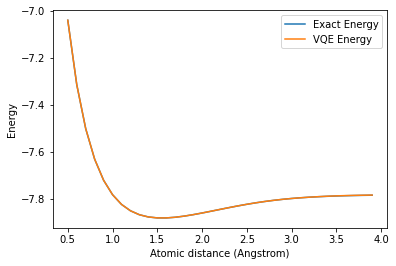

In [4]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()